<a href="https://colab.research.google.com/github/AnnaSafaryan/Kursaches/blob/main/Attribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка

In [5]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00


In [2]:
# !pip install -U pip setuptools wheel
# !pip install spacy
!python -m spacy download ru_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Импорты

In [124]:
import json
import re
import spacy
nlp = spacy.load("ru_core_news_lg")
from string import punctuation as punct
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np
from datasets import load_dataset
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Данные

In [13]:
train_df = pd.DataFrame(load_dataset('sagteam/author_profiling', split='train'))
valid_df = pd.DataFrame(load_dataset('sagteam/author_profiling', split='validation'))
test_df = pd.DataFrame(load_dataset('sagteam/author_profiling', split='test'))

In [19]:
df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=True)
df.head()

,id,text,account_id,author_id,age,age_group,gender,no_imitation,age_imitation,gender_imitation,style_imitation
0,crowdsource_4,здравствуйте. я покупал у вас путевку в тур. я...,account_#1009,2,21,20-29,male,no_any_imitation,None,no_gender_imitation,no_style_imitation
1,crowdsource_7,"Всем приветики ) Меня зовут Лена, На этом сайт...",account_#1010,5,18,0-19,male,with_any_imitation,None,with_gender_imitation,no_style_imitation
2,crowdsource_8,Уважаемый начальник. Принимая во внимание вашу...,account_#1011,6,39,30-39,male,with_any_imitation,None,with_gender_imitation,no_style_imitation
3,crowdsource_12,Приветик горячий парень с огненными глазами!Тв...,account_#1012,9,31,30-39,male,with_any_imitation,None,with_gender_imitation,no_style_imitation
4,crowdsource_13,Добрый день! Мне надоело ваше отношение ко мне...,account_#1013,10,45,40-49,male,no_any_imitation,None,no_gender_imitation,no_style_imitation


In [27]:
df = df[df['no_imitation'] == 'no_any_imitation']
df.head()

,id,text,account_id,author_id,age,age_group,gender,no_imitation,age_imitation,gender_imitation,style_imitation
0,crowdsource_4,здравствуйте. я покупал у вас путевку в тур. я...,account_#1009,2,21,20-29,male,no_any_imitation,None,no_gender_imitation,no_style_imitation
4,crowdsource_13,Добрый день! Мне надоело ваше отношение ко мне...,account_#1013,10,45,40-49,male,no_any_imitation,None,no_gender_imitation,no_style_imitation
6,crowdsource_15,Достоинства можно описывать с наибольшей долей...,account_#1015,12,34,30-39,male,no_any_imitation,None,no_gender_imitation,no_style_imitation
9,crowdsource_21,"Довожу до Вашего сведения, что я и моя супруга...",account_#1018,18,37,30-39,male,no_any_imitation,None,no_gender_imitation,no_style_imitation
10,crowdsource_24,"Привет, дорогая! Сейчас буду плакаться тебе, п...",account_#1019,21,28,20-29,female,no_any_imitation,None,no_gender_imitation,no_style_imitation


In [28]:
df = df[['text', 'age_group', 'gender']]
df.head()

,text,age_group,gender
0,здравствуйте. я покупал у вас путевку в тур. я...,20-29,male
4,Добрый день! Мне надоело ваше отношение ко мне...,40-49,male
6,Достоинства можно описывать с наибольшей долей...,30-39,male
9,"Довожу до Вашего сведения, что я и моя супруга...",30-39,male
10,"Привет, дорогая! Сейчас буду плакаться тебе, п...",20-29,female


In [93]:
df.loc[(df['age_group'] == '20-29') | (df['age_group'] == '30-39'), 'age_group'] = '20-39'
df.loc[(df['age_group'] == '40-49') | (df['age_group'] == '50+'), 'age_group'] = '40+'
df

,text,age_group,gender,parsed_text
0,здравствуйте. я покупал у вас путевку в тур. я...,20-39,male,"[[здравствуйте, .], [я, покупал, у, вас, путев..."
4,Добрый день! Мне надоело ваше отношение ко мне...,40+,male,"[[Добрый, день, !], [Мне, надоело, ваше, отнош..."
6,Достоинства можно описывать с наибольшей долей...,20-39,male,"[[Достоинства, можно, описывать, с, наибольшей..."
9,"Довожу до Вашего сведения, что я и моя супруга...",20-39,male,"[[Довожу, до, Вашего, сведения, ,, что, я, и, ..."
10,"Привет, дорогая! Сейчас буду плакаться тебе, п...",20-39,female,"[[Привет, ,, дорогая, !], [Сейчас, буду, плака..."
...,...,...,...,...
13433,"Привет, Дима. Как поживаешь? Как семья, дети? ...",40+,male,"[[Привет, ,, Дима, .], [Как, поживаешь, ?], [К..."
13436,"Привет! Я подвернула правую лодыжку, сижу дома...",40+,female,"[[Привет, !], [Я, подвернула, правую, лодыжку,..."
13439,"Привет!!! Как дела? Слушай, мы уже давно не в...",0-19,male,"[[ , Привет, !, !, !], [Как, дела, ?], [Слушай..."
13442,"Привет, Татьяна! Как же давно мы не виделись! ...",40+,female,"[[Привет, ,, Татьяна, !], [Как, же, давно, мы,..."


In [97]:
df.groupby('age_group').count()['text']

,text
age_group,
0-19,375
20-39,3202
40+,905


In [98]:
df.groupby('gender').count()['text']

,text
gender,
female,2261
male,2221


# Предобработка текстов

In [52]:
def parse_text(text):
    doc = nlp(text)
    parsed_text = [[token for token in sent] for sent in doc.sents]
    return parsed_text

In [59]:
df['parsed_text'] = df['text'].progress_apply(parse_text)

100%|██████████| 4482/4482 [03:19<00:00, 22.44it/s]

CPU times: user 3min 16s, sys: 965 ms, total: 3min 17s
Wall time: 3min 19s


In [62]:
df.head()

,text,age_group,gender,parsed_text
0,здравствуйте. я покупал у вас путевку в тур. я...,20-29,male,"[[здравствуйте, .], [я, покупал, у, вас, путев..."
4,Добрый день! Мне надоело ваше отношение ко мне...,40-49,male,"[[Добрый, день, !], [Мне, надоело, ваше, отнош..."
6,Достоинства можно описывать с наибольшей долей...,30-39,male,"[[Достоинства, можно, описывать, с, наибольшей..."
9,"Довожу до Вашего сведения, что я и моя супруга...",30-39,male,"[[Довожу, до, Вашего, сведения, ,, что, я, и, ..."
10,"Привет, дорогая! Сейчас буду плакаться тебе, п...",20-29,female,"[[Привет, ,, дорогая, !], [Сейчас, буду, плака..."


# Характеристики

## Длины

In [115]:
def count_lens(parsed_text):
    sents_per_doc = 0
    sent_lens = []
    syms_per_doc = 0
    words_per_doc = 0
    word_lens = []
    for sent in parsed_text:
        sents_per_doc += 1
        sent_words = 0
        for tok in sent:
            if tok.pos_ not in ["PUNCT", "SYM", "SPACE"]:
                syms_per_doc += len(tok.text)
                words_per_doc += 1
                sent_words += 1
                word_lens.append(len(tok.text))
        sent_lens.append(sent_words)

    return sents_per_doc, syms_per_doc, words_per_doc, float(np.mean(sent_lens)), float(np.mean(word_lens))

In [118]:
df[['sents_per_doc', 'syms_per_doc', 'words_per_doc', 'avg_sent_len', 'avg_word_lens']] = df['parsed_text'].progress_apply(lambda x: pd.Series(count_lens(x)))

100%|██████████| 4482/4482 [00:01<00:00, 3908.52it/s]


In [119]:
df

,text,age_group,gender,parsed_text,sents_per_doc,syms_per_doc,words_per_doc,avg_sent_len,avg_word_lens
0,здравствуйте. я покупал у вас путевку в тур. я...,20-39,male,"[[здравствуйте, .], [я, покупал, у, вас, путев...",12.0,454.0,99.0,8.250000,4.585859
4,Добрый день! Мне надоело ваше отношение ко мне...,40+,male,"[[Добрый, день, !], [Мне, надоело, ваше, отнош...",7.0,313.0,66.0,9.428571,4.742424
6,Достоинства можно описывать с наибольшей долей...,20-39,male,"[[Достоинства, можно, описывать, с, наибольшей...",4.0,478.0,82.0,20.500000,5.829268
9,"Довожу до Вашего сведения, что я и моя супруга...",20-39,male,"[[Довожу, до, Вашего, сведения, ,, что, я, и, ...",7.0,553.0,108.0,15.428571,5.120370
10,"Привет, дорогая! Сейчас буду плакаться тебе, п...",20-39,female,"[[Привет, ,, дорогая, !], [Сейчас, буду, плака...",10.0,516.0,110.0,11.000000,4.690909
...,...,...,...,...,...,...,...,...,...
13433,"Привет, Дима. Как поживаешь? Как семья, дети? ...",40+,male,"[[Привет, ,, Дима, .], [Как, поживаешь, ?], [К...",8.0,415.0,81.0,10.125000,5.123457
13436,"Привет! Я подвернула правую лодыжку, сижу дома...",40+,female,"[[Привет, !], [Я, подвернула, правую, лодыжку,...",15.0,435.0,86.0,5.733333,5.058140
13439,"Привет!!! Как дела? Слушай, мы уже давно не в...",0-19,male,"[[ , Привет, !, !, !], [Как, дела, ?], [Слушай...",18.0,589.0,138.0,7.666667,4.268116
13442,"Привет, Татьяна! Как же давно мы не виделись! ...",40+,female,"[[Привет, ,, Татьяна, !], [Как, же, давно, мы,...",12.0,415.0,81.0,6.750000,5.123457


## Части речи

In [165]:
pos_tags = ["VERB", "NOUN", "PROPN", "ADV", "ADJ",
            "PRON", "PART", "ADP", "CONJ", "SCONJ",
            "CCONJ", "INTJ", "DET", "AUX", "PUNCT",
            "NUM", "SYM", "SPACE", "X"]

def count_pos(parsed_text):
    pos_dict = {tag: 0 for tag in pos_tags}
    for sent in parsed_text:
        for tok in sent:
            pos_dict[tok.pos_] += 1
    return pos_dict.values()

In [166]:
count_pos(df['parsed_text'][0])

dict_values([18, 25, 0, 5, 5, 15, 1, 17, 0, 3, 1, 0, 2, 2, 25, 5, 0, 3, 0])

In [167]:
df[pos_tags] = df['parsed_text'].progress_apply(lambda x: pd.Series(count_pos(x)))

100%|██████████| 4482/4482 [00:00<00:00, 7972.03it/s] 


In [168]:
df

,text,age_group,gender,parsed_text,sents_per_doc,syms_per_doc,words_per_doc,avg_sent_len,avg_word_lens,VERB,...,SCONJ,CCONJ,INTJ,DET,AUX,PUNCT,NUM,SYM,SPACE,X
0,здравствуйте. я покупал у вас путевку в тур. я...,20-39,male,"[[здравствуйте, .], [я, покупал, у, вас, путев...",12.0,454.0,99.0,8.250000,4.585859,18,...,3,1,0,2,2,25,5,0,3,0
4,Добрый день! Мне надоело ваше отношение ко мне...,40+,male,"[[Добрый, день, !], [Мне, надоело, ваше, отнош...",7.0,313.0,66.0,9.428571,4.742424,15,...,1,3,0,2,1,12,0,0,0,0
6,Достоинства можно описывать с наибольшей долей...,20-39,male,"[[Достоинства, можно, описывать, с, наибольшей...",4.0,478.0,82.0,20.500000,5.829268,11,...,2,4,0,6,0,5,0,0,0,0
9,"Довожу до Вашего сведения, что я и моя супруга...",20-39,male,"[[Довожу, до, Вашего, сведения, ,, что, я, и, ...",7.0,553.0,108.0,15.428571,5.120370,21,...,5,7,0,6,1,18,3,0,1,0
10,"Привет, дорогая! Сейчас буду плакаться тебе, п...",20-39,female,"[[Привет, ,, дорогая, !], [Сейчас, буду, плака...",10.0,516.0,110.0,11.000000,4.690909,20,...,7,3,0,8,2,30,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13433,"Привет, Дима. Как поживаешь? Как семья, дети? ...",40+,male,"[[Привет, ,, Дима, .], [Как, поживаешь, ?], [К...",8.0,415.0,81.0,10.125000,5.123457,7,...,6,3,0,7,0,24,2,0,0,0
13436,"Привет! Я подвернула правую лодыжку, сижу дома...",40+,female,"[[Привет, !], [Я, подвернула, правую, лодыжку,...",15.0,435.0,86.0,5.733333,5.058140,14,...,2,5,0,2,1,20,0,0,3,0
13439,"Привет!!! Как дела? Слушай, мы уже давно не в...",0-19,male,"[[ , Привет, !, !, !], [Как, дела, ?], [Слушай...",18.0,589.0,138.0,7.666667,4.268116,23,...,10,8,0,1,2,39,3,0,2,0
13442,"Привет, Татьяна! Как же давно мы не виделись! ...",40+,female,"[[Привет, ,, Татьяна, !], [Как, же, давно, мы,...",12.0,415.0,81.0,6.750000,5.123457,18,...,0,3,0,2,1,24,0,0,1,0


# Статистика

In [142]:
df_male = df[df['gender'] == 'male']
df_female = df[df['gender'] == 'female']
df_019 = df[df['age_group'] == '0-19']
df_2039 = df[df['age_group'] == '20-39']
df_40 = df[df['age_group'] == '40+']
df_dict = {"мужчины": df_male, "женщины": df_female, "0-19": df_019, "20-39": df_2039, "40+": df_40}

## Нормальность распределения

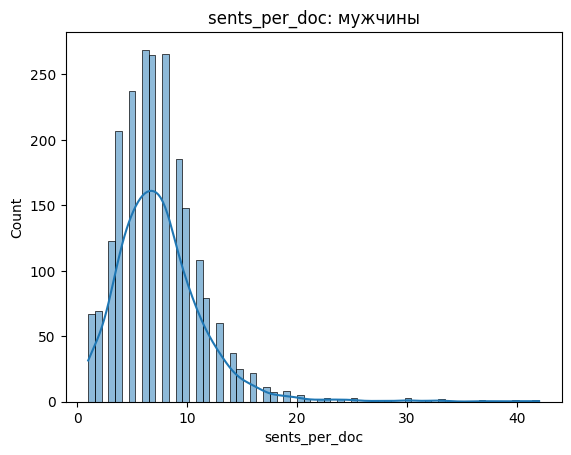

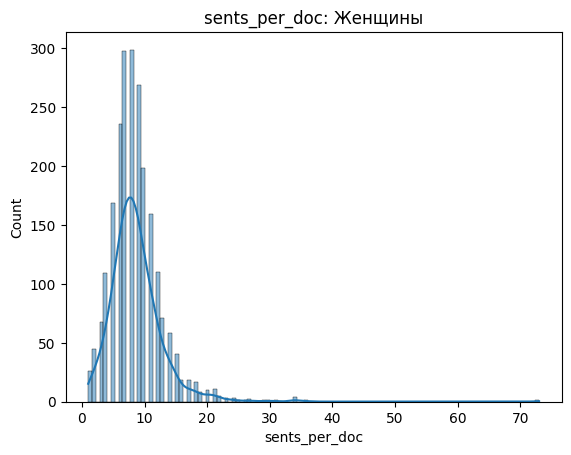

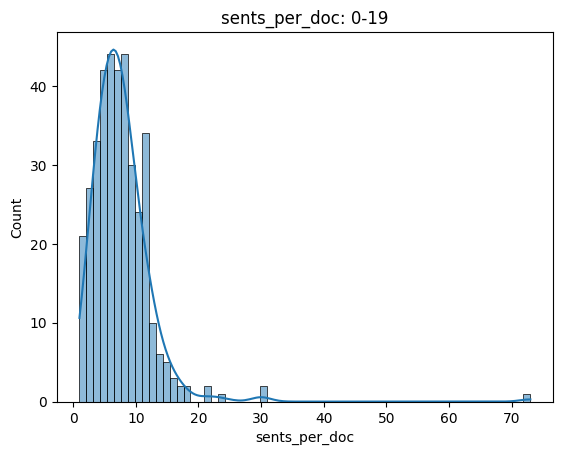

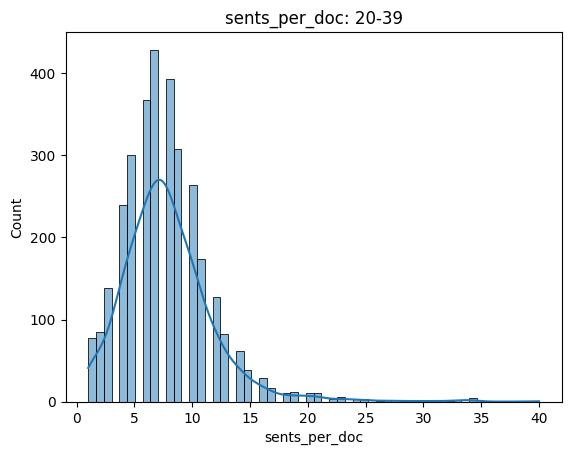

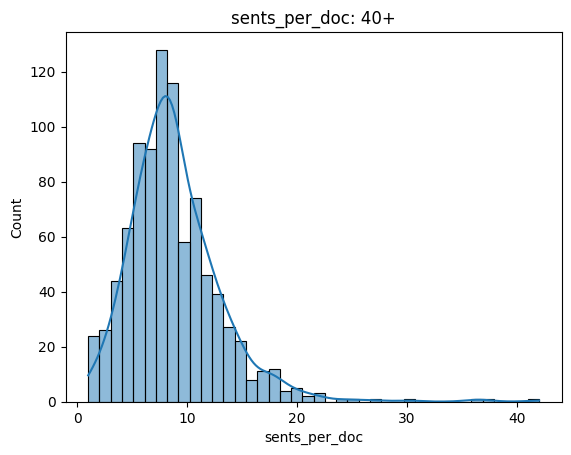

In [143]:
for df_name, df_elem in df_dict.items():
    sns.histplot(df_elem['sents_per_doc'], kde=True)
    plt.title(f"sents_per_doc: {df_name}")
    plt.show()